In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "450_20k_iso_kT100"
    npy_file_name_aniso = f"p_iso_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.00.npy"
    npy_file_name_aniso_energy = f"p_iso_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.00_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The 450_20k_iso_kT100 data size is: (76, 450, 450, 450)
READING DATA DONE
The 450_20k_iso_kT100 energy data size is: (76, 450, 450, 450)
READING ENERGY DATA DONE


In [3]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/3D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/3D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"].item()
                curvature_matrix_list.append(curvature_matrix)
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
                curvature_matrix_list.append(curvature_matrix)
            print("Finish curvature calculation")
            
            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    
                    # calculate or extract curvature
                    if pair_id not in curvature_matrix: continue
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

  0%|          | 0/51 [00:00<?, ?it/s]

Finish curvature calculation
Current GBs len at 0 steps: 171103


  2%|▏         | 1/51 [31:20<26:06:42, 1880.06s/it]

Finish curvature calculation
Current GBs len at 1 steps: 137947


  4%|▍         | 2/51 [52:44<20:49:26, 1529.92s/it]

Finish curvature calculation
Current GBs len at 2 steps: 119599


  6%|▌         | 3/51 [1:13:43<18:44:41, 1405.86s/it]

Finish curvature calculation
Current GBs len at 3 steps: 104767


  8%|▊         | 4/51 [1:34:20<17:29:10, 1339.38s/it]

Finish curvature calculation
Current GBs len at 4 steps: 92379


 10%|▉         | 5/51 [1:54:51<16:36:54, 1300.31s/it]

Finish curvature calculation
Current GBs len at 5 steps: 81423


 12%|█▏        | 6/51 [2:15:09<15:54:15, 1272.33s/it]

Finish curvature calculation
Current GBs len at 6 steps: 71986


 14%|█▎        | 7/51 [2:35:06<15:14:57, 1247.67s/it]

Finish curvature calculation
Current GBs len at 7 steps: 63909


 16%|█▌        | 8/51 [2:54:57<14:41:17, 1229.70s/it]

Finish curvature calculation


 18%|█▊        | 9/51 [3:14:42<14:11:01, 1215.75s/it]

Current GBs len at 8 steps: 56929
Finish curvature calculation


 20%|█▉        | 10/51 [3:34:19<13:42:30, 1203.67s/it]

Current GBs len at 9 steps: 51076
Finish curvature calculation
Current GBs len at 10 steps: 45855


 22%|██▏       | 11/51 [3:53:45<13:14:49, 1192.23s/it]

Finish curvature calculation


 24%|██▎       | 12/51 [4:13:10<12:49:26, 1183.75s/it]

Current GBs len at 11 steps: 41419
Finish curvature calculation


 25%|██▌       | 13/51 [4:32:24<12:24:09, 1175.00s/it]

Current GBs len at 12 steps: 37548
Finish curvature calculation
Current GBs len at 13 steps: 34155


 27%|██▋       | 14/51 [4:51:28<11:58:38, 1165.37s/it]

Finish curvature calculation


 29%|██▉       | 15/51 [5:10:36<11:36:09, 1160.26s/it]

Current GBs len at 14 steps: 31131
Finish curvature calculation


 31%|███▏      | 16/51 [5:29:43<11:14:32, 1156.35s/it]

Current GBs len at 15 steps: 28497
Finish curvature calculation


 33%|███▎      | 17/51 [5:48:40<10:51:57, 1150.52s/it]

Current GBs len at 16 steps: 26232
Finish curvature calculation


 35%|███▌      | 18/51 [6:07:42<10:31:22, 1147.95s/it]

Current GBs len at 17 steps: 24210
Finish curvature calculation


 37%|███▋      | 19/51 [6:26:23<10:07:58, 1139.94s/it]

Current GBs len at 18 steps: 22399
Finish curvature calculation


 39%|███▉      | 20/51 [6:45:16<9:47:48, 1137.69s/it] 

Current GBs len at 19 steps: 20742
Finish curvature calculation


 41%|████      | 21/51 [7:04:03<9:27:17, 1134.57s/it]

Current GBs len at 20 steps: 19343
Finish curvature calculation


 43%|████▎     | 22/51 [7:22:53<9:07:44, 1133.26s/it]

Current GBs len at 21 steps: 18124
Finish curvature calculation


 45%|████▌     | 23/51 [7:41:41<8:48:02, 1131.52s/it]

Current GBs len at 22 steps: 17009
Finish curvature calculation


 47%|████▋     | 24/51 [8:00:22<8:27:48, 1128.47s/it]

Current GBs len at 23 steps: 15979
Finish curvature calculation


 49%|████▉     | 25/51 [8:19:05<8:08:15, 1126.74s/it]

Current GBs len at 24 steps: 15097
Finish curvature calculation


 51%|█████     | 26/51 [8:37:39<7:47:54, 1123.00s/it]

Current GBs len at 25 steps: 14154
Finish curvature calculation


 53%|█████▎    | 27/51 [8:56:11<7:27:52, 1119.70s/it]

Current GBs len at 26 steps: 13289
Finish curvature calculation


 55%|█████▍    | 28/51 [9:14:39<7:07:51, 1116.14s/it]

Current GBs len at 27 steps: 12562
Finish curvature calculation


 57%|█████▋    | 29/51 [9:33:08<6:48:26, 1113.95s/it]

Current GBs len at 28 steps: 11881


 59%|█████▉    | 30/51 [9:51:37<6:29:22, 1112.50s/it]

Current GBs len at 29 steps: 11260
Finish curvature calculation


 61%|██████    | 31/51 [10:10:02<6:10:05, 1110.29s/it]

Current GBs len at 30 steps: 10789
Finish curvature calculation


 63%|██████▎   | 32/51 [10:28:30<5:51:21, 1109.54s/it]

Current GBs len at 31 steps: 10299
Finish curvature calculation


 65%|██████▍   | 33/51 [10:46:55<5:32:28, 1108.23s/it]

Current GBs len at 32 steps: 9827
Finish curvature calculation


 67%|██████▋   | 34/51 [11:05:14<5:13:10, 1105.31s/it]

Current GBs len at 33 steps: 9376
Finish curvature calculation


 69%|██████▊   | 35/51 [11:23:32<4:54:10, 1103.14s/it]

Current GBs len at 34 steps: 8944
Finish curvature calculation


 71%|███████   | 36/51 [11:41:51<4:35:30, 1102.05s/it]

Current GBs len at 35 steps: 8503
Finish curvature calculation


 73%|███████▎  | 37/51 [12:00:11<4:16:57, 1101.27s/it]

Current GBs len at 36 steps: 8176
Finish curvature calculation


 75%|███████▍  | 38/51 [12:18:22<3:57:56, 1098.23s/it]

Current GBs len at 37 steps: 7881
Finish curvature calculation


 76%|███████▋  | 39/51 [12:36:36<3:39:25, 1097.16s/it]

Current GBs len at 38 steps: 7609
Finish curvature calculation


 78%|███████▊  | 40/51 [12:54:39<3:20:21, 1092.83s/it]

Current GBs len at 39 steps: 7328
Finish curvature calculation


 80%|████████  | 41/51 [13:12:35<3:01:18, 1087.81s/it]

Current GBs len at 40 steps: 7012
Finish curvature calculation


 82%|████████▏ | 42/51 [13:30:30<2:42:35, 1083.90s/it]

Current GBs len at 41 steps: 6720
Finish curvature calculation


 84%|████████▍ | 43/51 [13:48:22<2:24:02, 1080.32s/it]

Current GBs len at 42 steps: 6452
Finish curvature calculation


 86%|████████▋ | 44/51 [14:06:16<2:05:48, 1078.31s/it]

Current GBs len at 43 steps: 6208
Finish curvature calculation


 88%|████████▊ | 45/51 [14:24:14<1:47:49, 1078.22s/it]

Current GBs len at 44 steps: 5919
Finish curvature calculation


 90%|█████████ | 46/51 [14:42:07<1:29:43, 1076.73s/it]

Current GBs len at 45 steps: 5685
Finish curvature calculation


 92%|█████████▏| 47/51 [14:59:49<1:11:29, 1072.38s/it]

Current GBs len at 46 steps: 5490
Finish curvature calculation


 94%|█████████▍| 48/51 [15:17:34<53:30, 1070.16s/it]  

Current GBs len at 47 steps: 5278
Finish curvature calculation


 96%|█████████▌| 49/51 [15:35:22<35:38, 1069.34s/it]

Current GBs len at 48 steps: 5096
Finish curvature calculation


 98%|█████████▊| 50/51 [15:53:04<17:47, 1067.17s/it]

Current GBs len at 49 steps: 4943
Finish curvature calculation


100%|██████████| 51/51 [16:10:52<00:00, 1142.20s/it]

Current GBs len at 50 steps: 4799


In [4]:
    # GB Energy information
    step_num=51
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

  0%|          | 0/51 [00:00<?, ?it/s]

Current GBs len at 0 steps: 183290


  2%|▏         | 1/51 [18:32<15:26:57, 1112.36s/it]

Current GBs len at 2 steps: 121442


  6%|▌         | 3/51 [45:00<11:29:34, 861.97s/it]

Current GBs len at 3 steps: 106307


  8%|▊         | 4/51 [57:29<10:40:13, 817.30s/it]

Current GBs len at 4 steps: 93602


 10%|▉         | 5/51 [1:09:43<10:03:44, 787.50s/it]

Current GBs len at 5 steps: 82563


 12%|█▏        | 6/51 [1:21:35<9:31:21, 761.82s/it] 

Current GBs len at 6 steps: 72964


 14%|█▎        | 7/51 [1:33:06<9:01:40, 738.66s/it]

Current GBs len at 7 steps: 64718


 18%|█▊        | 9/51 [1:55:33<8:12:50, 704.07s/it]

Current GBs len at 8 steps: 57581


 20%|█▉        | 10/51 [2:06:26<7:50:18, 688.26s/it]

Current GBs len at 9 steps: 51633
Current GBs len at 10 steps: 46314


 24%|██▎       | 12/51 [2:27:33<7:08:47, 659.68s/it]

Current GBs len at 11 steps: 41853
Current GBs len at 12 steps: 37917


 27%|██▋       | 14/51 [2:48:08<6:33:16, 637.73s/it]

Current GBs len at 13 steps: 34430


 29%|██▉       | 15/51 [2:58:07<6:15:35, 625.98s/it]

Current GBs len at 14 steps: 31429


 31%|███▏      | 16/51 [3:08:07<6:00:43, 618.39s/it]

Current GBs len at 15 steps: 28736


 33%|███▎      | 17/51 [3:17:59<5:45:50, 610.32s/it]

Current GBs len at 16 steps: 26433


 35%|███▌      | 18/51 [3:27:40<5:30:49, 601.51s/it]

Current GBs len at 17 steps: 24407
Current GBs len at 18 steps: 22556


 39%|███▉      | 20/51 [3:46:49<5:03:35, 587.60s/it]

Current GBs len at 19 steps: 20898


 41%|████      | 21/51 [3:56:14<4:50:20, 580.68s/it]

Current GBs len at 20 steps: 19463


 43%|████▎     | 22/51 [4:05:41<4:38:40, 576.57s/it]

Current GBs len at 21 steps: 18245


 45%|████▌     | 23/51 [4:15:02<4:26:53, 571.91s/it]

Current GBs len at 22 steps: 17123


 47%|████▋     | 24/51 [4:24:17<4:15:06, 566.89s/it]

Current GBs len at 23 steps: 16084


 49%|████▉     | 25/51 [4:33:19<4:02:26, 559.48s/it]

Current GBs len at 24 steps: 15189


 51%|█████     | 26/51 [4:42:28<3:51:45, 556.22s/it]

Current GBs len at 25 steps: 14245


 53%|█████▎    | 27/51 [4:51:24<3:40:08, 550.37s/it]

Current GBs len at 26 steps: 13350


 55%|█████▍    | 28/51 [5:00:18<3:29:02, 545.32s/it]

Current GBs len at 27 steps: 12629
Current GBs len at 28 steps: 11945


 59%|█████▉    | 30/51 [5:18:04<3:08:43, 539.19s/it]

Current GBs len at 29 steps: 11299


 61%|██████    | 31/51 [5:26:57<2:59:03, 537.20s/it]

Current GBs len at 30 steps: 10854


 63%|██████▎   | 32/51 [5:35:43<2:49:03, 533.86s/it]

Current GBs len at 31 steps: 10354


 65%|██████▍   | 33/51 [5:44:24<2:39:00, 530.03s/it]

Current GBs len at 32 steps: 9870


 67%|██████▋   | 34/51 [5:53:00<2:28:59, 525.84s/it]

Current GBs len at 33 steps: 9425


 69%|██████▊   | 35/51 [6:01:32<2:19:07, 521.73s/it]

Current GBs len at 34 steps: 8981


 71%|███████   | 36/51 [6:10:01<2:09:29, 517.97s/it]

Current GBs len at 35 steps: 8537


 73%|███████▎  | 37/51 [6:18:31<2:00:17, 515.53s/it]

Current GBs len at 36 steps: 8207


 75%|███████▍  | 38/51 [6:26:59<1:51:12, 513.25s/it]

Current GBs len at 37 steps: 7910


 76%|███████▋  | 39/51 [6:35:33<1:42:40, 513.37s/it]

Current GBs len at 38 steps: 7635


 78%|███████▊  | 40/51 [6:44:00<1:33:48, 511.68s/it]

Current GBs len at 39 steps: 7357


 80%|████████  | 41/51 [6:52:20<1:24:41, 508.19s/it]

Current GBs len at 40 steps: 7050


 82%|████████▏ | 42/51 [7:00:37<1:15:43, 504.89s/it]

Current GBs len at 41 steps: 6746


 84%|████████▍ | 43/51 [7:08:53<1:06:55, 501.93s/it]

Current GBs len at 42 steps: 6486


 86%|████████▋ | 44/51 [7:17:06<58:15, 499.42s/it]  

Current GBs len at 43 steps: 6232


 88%|████████▊ | 45/51 [7:25:16<49:39, 496.60s/it]

Current GBs len at 44 steps: 5946


 90%|█████████ | 46/51 [7:33:27<41:15, 495.03s/it]

Current GBs len at 45 steps: 5717


 92%|█████████▏| 47/51 [7:41:41<32:58, 494.51s/it]

Current GBs len at 46 steps: 5512


 94%|█████████▍| 48/51 [7:49:50<24:38, 492.93s/it]

Current GBs len at 47 steps: 5291


 96%|█████████▌| 49/51 [7:57:55<16:20, 490.48s/it]

Current GBs len at 48 steps: 5122


 98%|█████████▊| 50/51 [8:05:59<08:08, 488.62s/it]

Current GBs len at 49 steps: 4953


100%|██████████| 51/51 [8:14:10<00:00, 581.37s/it]

Current GBs len at 50 steps: 4818


In [5]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < 100 or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/3D_dV_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 171103
key num end with 63433


100%|██████████| 63433/63433 [1:29:27<00:00, 11.82it/s]


finish 0 with num of GBs 63433, and collected num of GBs 33845
key num start with 137947
key num end with 52552


100%|██████████| 52552/52552 [1:13:58<00:00, 11.84it/s]


finish 1 with num of GBs 52552, and collected num of GBs 56912
key num start with 119599
key num end with 48864


100%|██████████| 48864/48864 [1:09:13<00:00, 11.77it/s]


finish 2 with num of GBs 48864, and collected num of GBs 68472
key num start with 104767
key num end with 44513


 29%|██▉       | 13107/44513 [18:21<44:25, 11.78it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 92%|█████████▏| 40777/44513 [58:24<05:42, 10.91it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 40251/40251 [57:23<00:00, 11.69it/s]


finish 4 with num of GBs 40251, and collected num of GBs 80952
key num start with 81423
key num end with 36420


100%|██████████| 36420/36420 [51:22<00:00, 11.81it/s]


finish 5 with num of GBs 36420, and collected num of GBs 84844
key num start with 71986
key num end with 33093


100%|██████████| 33093/33093 [46:11<00:00, 11.94it/s]


finish 6 with num of GBs 33093, and collected num of GBs 87991
key num start with 63909
key num end with 29865


100%|██████████| 29865/29865 [41:40<00:00, 11.94it/s]


finish 7 with num of GBs 29865, and collected num of GBs 90674
key num start with 56929
key num end with 27085


100%|██████████| 27085/27085 [37:49<00:00, 11.93it/s]


finish 8 with num of GBs 27085, and collected num of GBs 92876
key num start with 51076
key num end with 24790


100%|██████████| 24790/24790 [34:35<00:00, 11.94it/s]


finish 9 with num of GBs 24790, and collected num of GBs 94813
key num start with 45855
key num end with 22617


100%|██████████| 22617/22617 [31:44<00:00, 11.87it/s]


finish 10 with num of GBs 22617, and collected num of GBs 96477
key num start with 41419
key num end with 20651


100%|██████████| 20651/20651 [28:45<00:00, 11.97it/s]


finish 11 with num of GBs 20651, and collected num of GBs 97855
key num start with 37548
key num end with 18853


100%|██████████| 18853/18853 [26:22<00:00, 11.92it/s]


finish 12 with num of GBs 18853, and collected num of GBs 99050
key num start with 34155
key num end with 17256


100%|██████████| 17256/17256 [24:13<00:00, 11.87it/s]


finish 13 with num of GBs 17256, and collected num of GBs 100124
key num start with 31131
key num end with 15894


100%|██████████| 15894/15894 [22:20<00:00, 11.85it/s]


finish 14 with num of GBs 15894, and collected num of GBs 101038
key num start with 28497
key num end with 14644


100%|██████████| 14644/14644 [20:38<00:00, 11.82it/s]


finish 15 with num of GBs 14644, and collected num of GBs 101862
key num start with 26232
key num end with 13564


100%|██████████| 13564/13564 [20:22<00:00, 11.10it/s]


finish 16 with num of GBs 13564, and collected num of GBs 102599
key num start with 24210
key num end with 12532


100%|██████████| 12532/12532 [18:50<00:00, 11.09it/s]


finish 17 with num of GBs 12532, and collected num of GBs 103224
key num start with 22399
key num end with 11610


100%|██████████| 11610/11610 [09:43<00:00, 19.91it/s]


finish 18 with num of GBs 11610, and collected num of GBs 103780
key num start with 20742
key num end with 10817


100%|██████████| 10817/10817 [10:00<00:00, 18.03it/s]


finish 19 with num of GBs 10817, and collected num of GBs 104274
key num start with 19343
key num end with 10072


100%|██████████| 10072/10072 [12:13<00:00, 13.73it/s]


finish 20 with num of GBs 10072, and collected num of GBs 104751
key num start with 18124
key num end with 9515


100%|██████████| 9515/9515 [13:22<00:00, 11.85it/s]


finish 21 with num of GBs 9515, and collected num of GBs 105104
key num start with 17009
key num end with 8895


100%|██████████| 8895/8895 [12:32<00:00, 11.82it/s]


finish 22 with num of GBs 8895, and collected num of GBs 105480
key num start with 15979
key num end with 8327


100%|██████████| 8327/8327 [12:17<00:00, 11.30it/s]


finish 23 with num of GBs 8327, and collected num of GBs 105800
key num start with 15097
key num end with 7760


100%|██████████| 7760/7760 [11:18<00:00, 11.43it/s]


finish 24 with num of GBs 7760, and collected num of GBs 106065
key num start with 14154
key num end with 7359


 41%|████▏     | 3038/7359 [04:24<06:07, 11.76it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 6139/6139 [09:02<00:00, 11.31it/s]


finish 28 with num of GBs 6139, and collected num of GBs 107019
key num start with 11260
key num end with 5849


 32%|███▏      | 1894/5849 [02:46<06:00, 10.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 5245/5245 [07:32<00:00, 11.60it/s]


finish 31 with num of GBs 5245, and collected num of GBs 107495
key num start with 9827
key num end with 4969


100%|██████████| 4969/4969 [07:12<00:00, 11.49it/s]


finish 32 with num of GBs 4969, and collected num of GBs 107642
key num start with 9376
key num end with 4723


100%|██████████| 4723/4723 [06:48<00:00, 11.56it/s]


finish 33 with num of GBs 4723, and collected num of GBs 107781
key num start with 8944
key num end with 4511


100%|██████████| 4511/4511 [06:31<00:00, 11.53it/s]


finish 34 with num of GBs 4511, and collected num of GBs 107916
key num start with 8503
key num end with 4286


100%|██████████| 4286/4286 [06:06<00:00, 11.68it/s]


finish 35 with num of GBs 4286, and collected num of GBs 108028
key num start with 8176
key num end with 4153


100%|██████████| 4153/4153 [06:02<00:00, 11.47it/s]


finish 36 with num of GBs 4153, and collected num of GBs 108140
key num start with 7881
key num end with 4013


100%|██████████| 4013/4013 [05:56<00:00, 11.26it/s]


finish 37 with num of GBs 4013, and collected num of GBs 108232
key num start with 7609
key num end with 3857


 71%|███████▏  | 2750/3857 [03:11<01:13, 15.06it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 2785/2785 [03:40<00:00, 12.66it/s]


finish 45 with num of GBs 2785, and collected num of GBs 108850
key num start with 5490
key num end with 2586


100%|██████████| 2586/2586 [03:44<00:00, 11.52it/s]


finish 46 with num of GBs 2586, and collected num of GBs 108904
key num start with 5278
key num end with 2565


 97%|█████████▋| 2478/2565 [02:49<00:06, 14.41it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
    time_interval = 2
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/3D_dV_data_{case_name}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
            
        
            

100%|██████████| 51/51 [00:06<00:00,  7.85it/s]


In [9]:
    total_GB = set()
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        total_GB = total_GB | step_GB

    anti_c_num = 0
    for key in GB_id_focus:
        anti_c_num += GB_id_focus[key]
    print(f"The number of the GBs showing anti-curvature during whole simulations is {anti_c_num}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {anti_c_num/total_GB_num*100}% in {total_GB_num} GBs")
    # print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 424182
The ratio of anti-curvature GBs during whole simulations is 27.11575119954895% in 1564338 GBs


<Figure size 432x288 with 0 Axes>

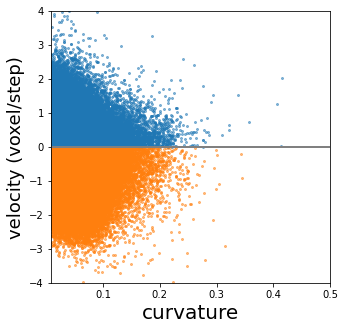

<Figure size 432x288 with 0 Axes>

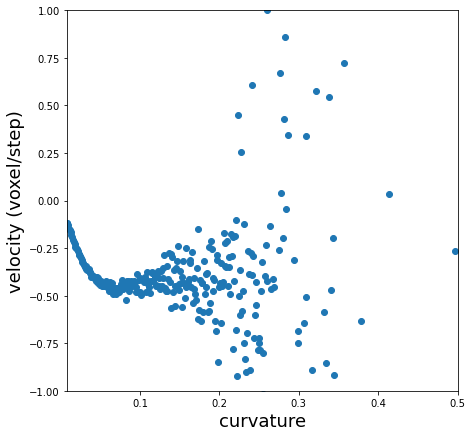

In [8]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    area_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
        area_1Dlist_remove_0step.extend(GB_list_area_list[i])
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_remove_0step)):
        if curvature_1Dlist_remove_0step[i]<0: 
            curvature_1Dlist_remove_0step[i] = - curvature_1Dlist_remove_0step[i]
            velocity_1Dlist_remove_0step[i] = - velocity_1Dlist_remove_0step[i]
    velocity_1Dlist_remove_0step = np.array(velocity_1Dlist_remove_0step)
    curvature_1Dlist_remove_0step = np.array(curvature_1Dlist_remove_0step)
    area_1Dlist_remove_0step = np.array(area_1Dlist_remove_0step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_remove_0step)):
        if abs(curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'area')

<Figure size 432x288 with 0 Axes>

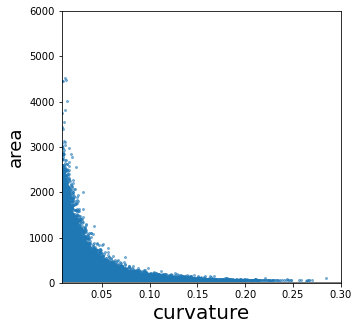

<Figure size 432x288 with 0 Axes>

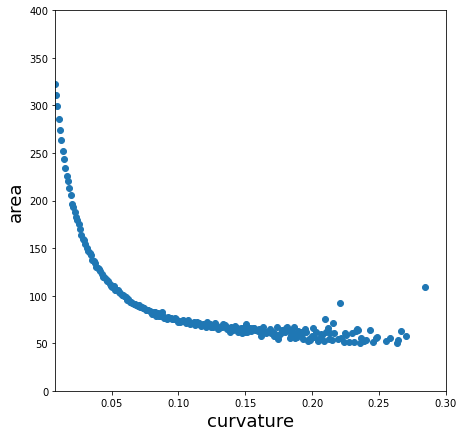

In [52]:
    # curvature VS area
    figure_name_all = f"figures/3D_signedcurvature_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_remove_0step, area_1Dlist_remove_0step,s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0],s=4,alpha=0.5,color='C01')
    # plt.scatter(GB_antic_list_curvature_list, GB_antic_list_area_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("area", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([0,6000])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot average
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_remove_0step)):
        if abs(curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        area_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += area_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: area_bin[i] = area_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_signedcurvature_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([curvature_limit,0.30])
    plt.ylim([0,400])
    plt.plot(curvature_coordinate[area_bin!=0], area_bin[area_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("area", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

In [53]:
len(GB_antic_list_velocity_list)

468283

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

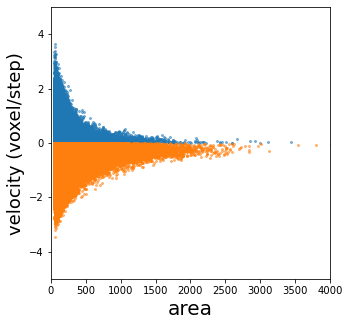

<Figure size 432x288 with 0 Axes>

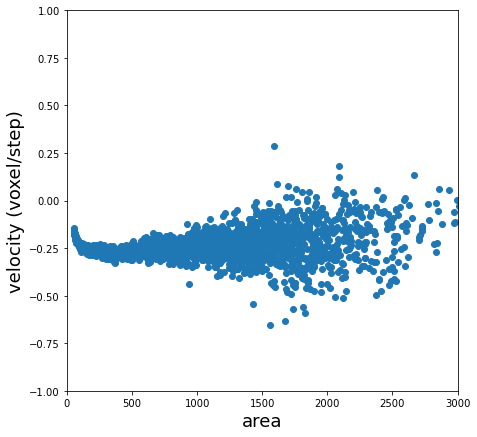

In [64]:
    # area VS velocity
    figure_name_all = f"figures/3D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(area_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(GB_antic_list_area_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0,4000])
    plt.ylim([-5,5])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged area
    bin_interval = 1
    x_lim = [0.0,6000]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(area_1Dlist_remove_0step)):
        if abs(area_1Dlist_remove_0step[index])>x_lim[1]: continue
        area_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.0,3000])
    plt.ylim([-1,1])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'anti-curvature fraction')

<Figure size 432x288 with 0 Axes>

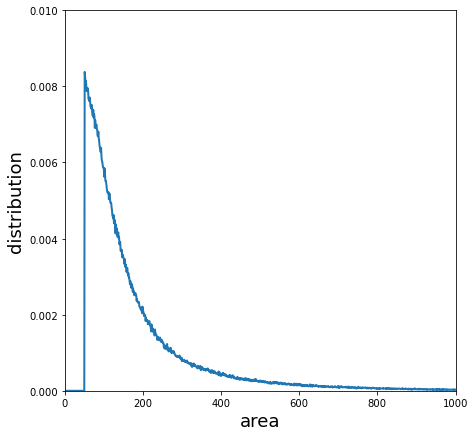

<Figure size 432x288 with 0 Axes>

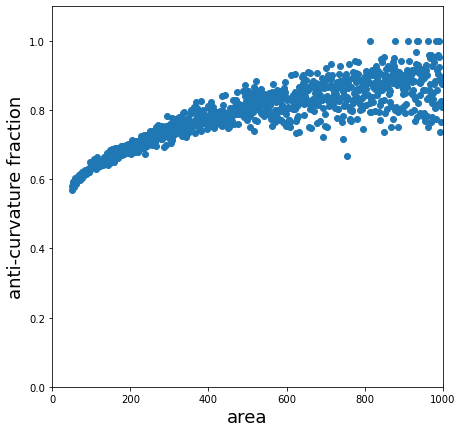

In [65]:
    # anti-c fraction VS area bin
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,1000])
    plt.ylim([0,0.01])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,1000])
    plt.ylim([0,1.1])
    plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)

0.22668690014400725


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

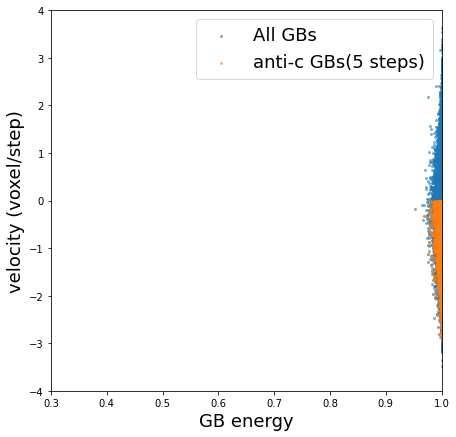

<Figure size 432x288 with 0 Axes>

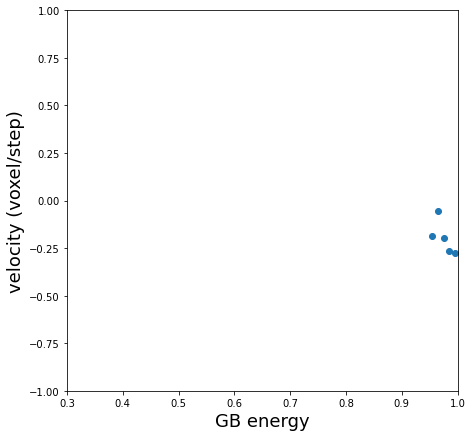

<Figure size 432x288 with 0 Axes>

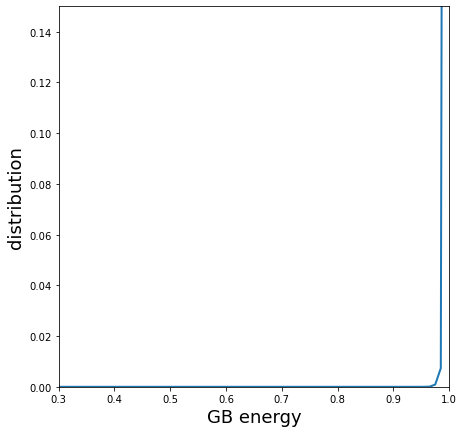

<Figure size 432x288 with 0 Axes>

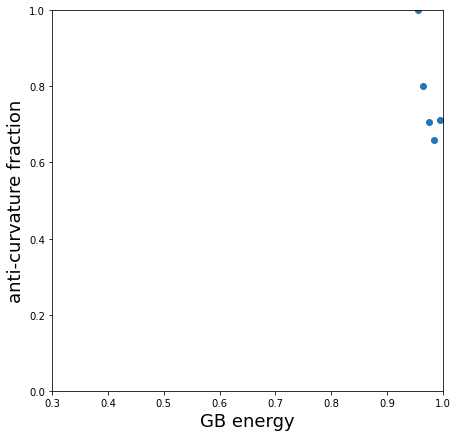

<Figure size 432x288 with 0 Axes>

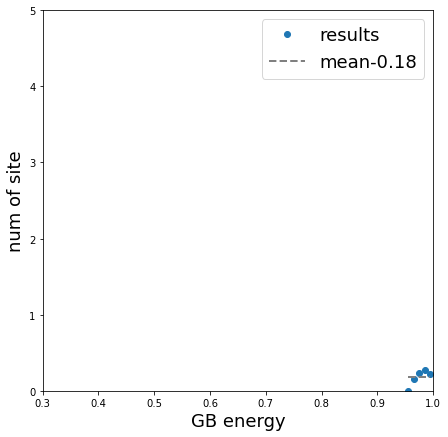

In [11]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


## For one time step

In [20]:
 
    expected_grain_num = 1000
    
    # get corresponding step
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    for time_step in tqdm(range(npy_file_aniso.shape[0])):
        # Calculate the number of grains
        unique_id_num = len(np.unique(npy_file_aniso[time_step,:]))
        grain_num_array[time_step] = unique_id_num
        if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less
    expected_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))
    

 51%|█████▏    | 39/76 [01:16<01:12,  1.97s/it]


In [21]:
    # fraction
    total_GB_num_1step = len(GB_infomation_dict_list[expected_step].keys())
    anti_c_num_1step = 0
    for key in GB_id_focus_detail:
        if expected_step in GB_id_focus_detail[key]: anti_c_num_1step += 1
    print(f"Anti-curvature GBs at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step}")
    print(f"Anti-curvature fraction at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step/total_GB_num_1step*100}% in {total_GB_num_1step} GBs")



Anti-curvature GBs at step 36 with 1000 grains is 2370
Anti-curvature fraction at step 36 with 1000 grains is 34.89399293286219% in 6792 GBs


<Figure size 432x288 with 0 Axes>

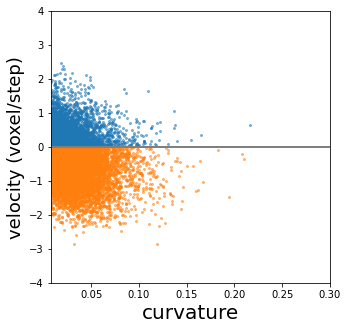

<Figure size 432x288 with 0 Axes>

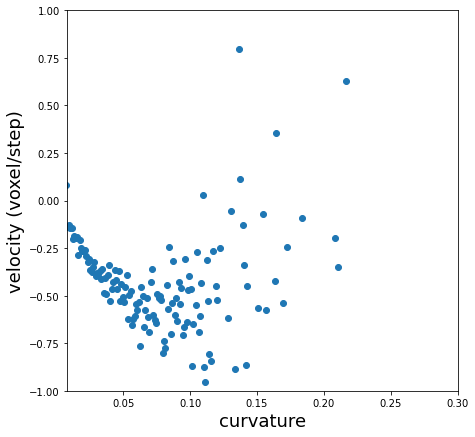

In [12]:
    # All in 1 figrue
    curvature_1Dlist_1step = GB_list_curvature_list[expected_step]
    velocity_1Dlist_1step = GB_list_velocity_list[expected_step]
    GBenergy_1Dlist_1step = GB_list_GBenergy_list[expected_step]
    GB_antic_list_curvature_1step = GB_antic_list_curvature_AllList[expected_step]
    GB_antic_list_velocity_1step = GB_antic_list_velocity_AllList[expected_step]
    GB_antic_list_GBenergy_1step = GB_antic_list_GBenergy_AllList[expected_step]
    GB_antic_list_anticNum_1step = GB_antic_list_anticNum_AllList[expected_step]
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_1step)):
        if curvature_1Dlist_1step[i]<0: 
            curvature_1Dlist_1step[i] = - curvature_1Dlist_1step[i]
            velocity_1Dlist_1step[i] = - velocity_1Dlist_1step[i]
    velocity_1Dlist_1step = np.array(velocity_1Dlist_1step)
    curvature_1Dlist_1step = np.array(curvature_1Dlist_1step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step>0], velocity_1Dlist_1step[velocity_1Dlist_1step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step<0], velocity_1Dlist_1step[velocity_1Dlist_1step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_1step, GB_antic_list_velocity_1step,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_1step)):
        if abs(curvature_1Dlist_1step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.20764253442762368


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

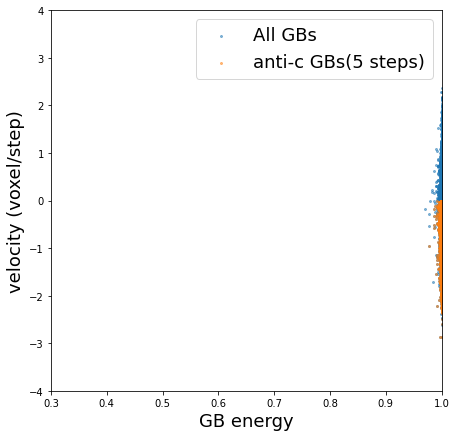

<Figure size 432x288 with 0 Axes>

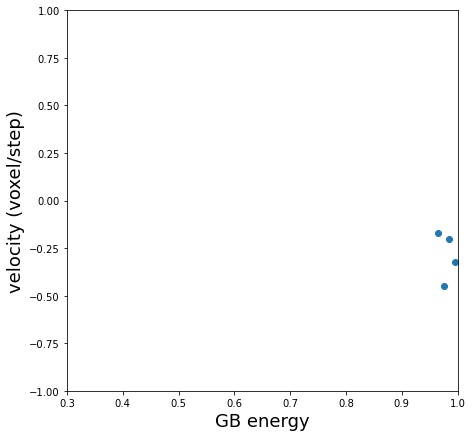

<Figure size 432x288 with 0 Axes>

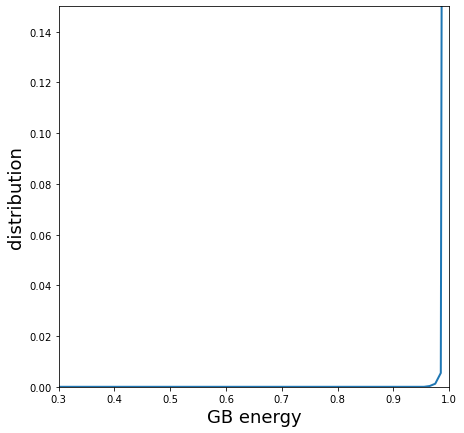

<Figure size 432x288 with 0 Axes>

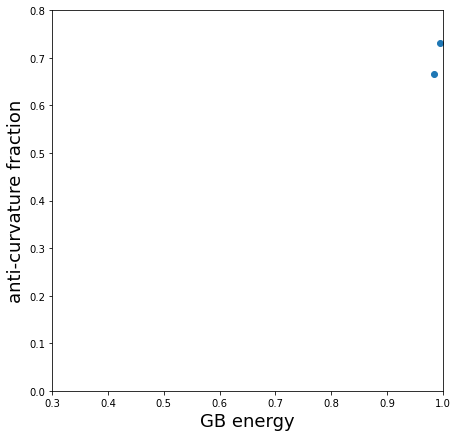

<Figure size 432x288 with 0 Axes>

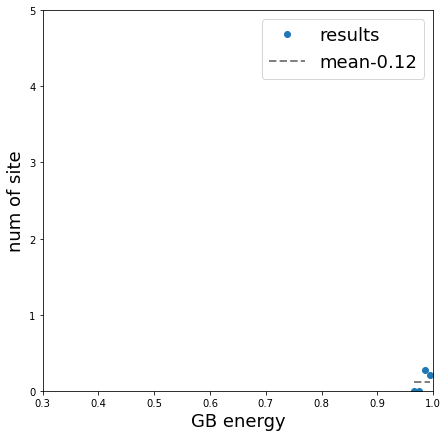

In [13]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_1step, velocity_1Dlist_1step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_1step = np.array(GB_antic_list_GBenergy_1step)
    GB_antic_list_velocity_1step = np.array(GB_antic_list_velocity_1step)
    GB_antic_list_anticNum_1step = np.array(GB_antic_list_anticNum_1step)
    plt.scatter(GB_antic_list_GBenergy_1step[GB_antic_list_anticNum_1step>=5], GB_antic_list_velocity_1step[GB_antic_list_anticNum_1step>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_1step)):
        if abs(GBenergy_1Dlist_1step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
        if velocity_1Dlist_1step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_1step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}_{expected_grain_num}grains"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        
